In [1]:
# Kernel preparation

# Warning suppression
import warnings
warnings.simplefilter('ignore')
import numpy as np
np.warnings.filterwarnings('ignore')
np.random.seed(1001)
# Cliche
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import shutil
from pathlib import Path
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
matplotlib.style.use('ggplot')

def play_audio(data):
    IPython.display.display(IPython.display.Audio(data=data))

In [2]:
## External dependencies - mixup & random eraser
#
# Downloaded from https://github.com/yu4u/mixup-generator
#

import numpy as np


class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [15]:
confLH, confX = {}, {}
confs = [confLH, confX]
confLH['folder'] = Path('train/Normalised_audio-chunks/')
confX['folder'] = Path('train/Normalised_audio-chunks/')


In [16]:

# confs = [confLH]
# confLH['folder'] = Path('train/Normalised_audio-chunks/')

# Approach LH parameters: highest resolutions
confLH['sampling_rate'] = 44100
confLH['duration'] = 4

confLH['hop_length'] = 882 # 20ms
confLH['fmin'] = 20
confLH['fmax'] = confLH['sampling_rate'] // 2
confLH['n_mels'] = 128
confLH['n_fft'] = confLH['n_mels'] * 20
confLH['audio_split'] = 'head'

# Approach X uses longer sound, then it uses suppressed 
confX['sampling_rate'] = 26000
confX['duration'] = 6
confX['hop_length'] = 520 # 20ms
confX['fmin'] = 20
confX['fmax'] = confX['sampling_rate'] // 2
confX['n_mels'] = 48
confX['n_fft'] = confX['n_mels'] * 20
confX['audio_split'] = 'dont_crop'


# Auto calculate other configuration paramters

def auto_complete_conf(conf):
    conf['samples'] = conf['sampling_rate'] * conf['duration']
    conf['dims'] = (conf['n_mels'], 1 + int(np.floor(conf['samples']/conf['hop_length'])), 1)

auto_complete_conf(confLH)
auto_complete_conf(confX)

In [18]:
confX

{'folder': WindowsPath('train/Normalised_audio-chunks'),
 'sampling_rate': 26000,
 'duration': 6,
 'hop_length': 520,
 'fmin': 20,
 'fmax': 13000,
 'n_mels': 48,
 'n_fft': 960,
 'audio_split': 'dont_crop',
 'samples': 156000,
 'dims': (48, 301, 1)}

In [5]:
import librosa
import librosa.display

def read_audio(conf, pathname):
    y, sr = librosa.load(pathname, sr=conf['sampling_rate'])
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf['samples']: # long enough
        if conf['audio_split'] == 'head':
            y = y[0:0+conf['samples']]
    else: # pad blank
        padding = conf['samples'] - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf['samples'] - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf['sampling_rate'],
                                                 n_mels=conf['n_mels'],
                                                 hop_length=conf['hop_length'],
                                                 n_fft=conf['n_fft'],
                                                 fmin=conf['fmin'],
                                                 fmax=conf['fmax'])
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(mels, conf):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf['sampling_rate'], hop_length=conf['hop_length'],
                            fmin=conf['fmin'], fmax=conf['fmax'])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')
    plt.show()

def read_as_melspectrogram(conf, pathname, debug_display=False):
    x = read_audio(conf, pathname)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf['sampling_rate']))
        show_melspectrogram(mels, conf)
    return mels


In [6]:
import pandas as pd

rootdir = 'train/Normalised_audio-chunks'

data = []
for control in os.listdir(rootdir):
    Class = 0
    if control == 'cc':
        Class = 0
    else:
        Class = 1
        
    sub_dir = rootdir + '/' + control

    for sample in os.listdir(sub_dir):
        data.append([control + '/' + sample,Class])
        
df_train = pd.DataFrame(data, columns = ['fname', 'labels'])


In [7]:
df_train

,fname,labels
0,cc/S001-7-13310-20608-1-0-340.wav,0
1,cc/S001-7-13310-20608-2-2680-3630.wav,0
2,cc/S001-7-13310-20608-3-4160-4880.wav,0
3,cc/S001-7-13310-20608-4-6660-7300.wav,0
4,cc/S001-7-20608-27071-1-320-980.wav,0
...,...,...
2829,cd/S156-306-46800-50941-1-0-870.wav,1
2830,cd/S156-306-46800-50941-2-1160-2530.wav,1
2831,cd/S156-306-46800-50941-3-2890-4150.wav,1
2832,cd/S156-306-58602-64417-1-3530-5790.wav,1


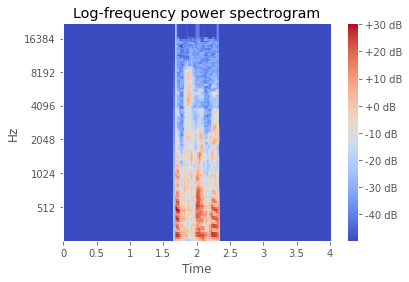

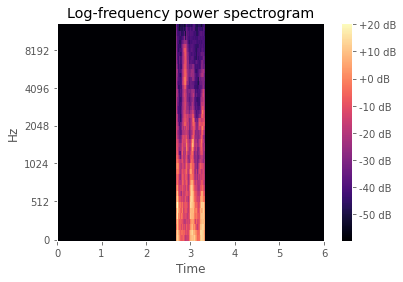

In [21]:
#  Preprocessing examples
_ = read_as_melspectrogram(confLH, 'train/Normalised_audio-chunks/' + df_train.fname[765], debug_display=True)
_ = read_as_melspectrogram(confX, 'train/Normalised_audio-chunks/' + df_train.fname[765], debug_display=True)


In [9]:
def split_long_data(conf, X):
    # Splits long mel-spectrogram data with small overlap
    L = X.shape[1]
    one_length = conf['dims'][1]
    loop_length = int(one_length * 0.9)
    min_length = int(one_length * 0.2)
    print(' sample length', L, 'to cut every', one_length)
    for idx in range(L // loop_length):
        cur = loop_length * idx
        rest = L - cur
        if one_length <= rest:
            yield X[:, cur:cur+one_length]
        elif min_length <= rest:
            cur = L - one_length
            yield X[:, cur:cur+one_length]

def convert_X(df, conf, datapath):
    # Convert all files listed on df.fname
    # Then generates X (contains mel-spectrograms)
    # and index mapping to original sample order
    X = []
    index_map = []
    for i, fname in enumerate(df.fname):
        print('processing', fname)
        data = read_as_melspectrogram(conf, datapath + fname)
        for chunk in split_long_data(conf, data):
            X.append(np.expand_dims(chunk, axis=-1))
            index_map.append(i)
    return np.array(X), np.array(index_map)

def convert_y_train(idx_train, plain_y_train):
    return np.array( [plain_y_train[idx] for idx in idx_train])


In [23]:
# Example - process up to 10 samples
DATAROOT = 'train/Normalised_audio-chunks'
print('All samples will be cut per split length (=duration)')
X_train, idx_train = convert_X(df_train[:10], confX, DATAROOT + 'audio_train')
y_train = convert_y_train(idx_train, plain_y_train)
print('Now original 10 samples were cut into ', len(idx_train), 'samples.')
print()
print('idx_train holds original sample index, y_train is also converted to have the same length with X_train/idx_train.')
print('idx_train', idx_train)
print('y_train', y_train)

All samples will be cut per split length (=duration)


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [22]:
# Data utilities
def datapath(conf, filename):
    return conf['folder'] + '/' +  filename

def loaddata(conf, filename):
    return np.load(conf['folder'] + '/' + filename)

#### This is Toy example by default ####
TRYING_AS_TOY = True # False if you like creating full set

for conf in confs:
    conf['folder'].mkdir(parents=True, exist_ok=True)
    if TRYING_AS_TOY:
        for file in ['X_train', 'y_train', 'idx_train', 'X_test', 'idx_test']:
            shutil.copy(EXTRA/datapath(conf, file+'.npy'), datapath(conf, file+'.npy'))
        plain_y_train = np.load(EXTRA/'toy_plain_y_train.npy')
        train_verified_idx = np.load(EXTRA/'toy_train_verified_idx.npy')
        train_blacklist_index = np.load(EXTRA / 'toy_train_blacklist.npy')
    else:
        if not os.path.exists(datapath(conf, 'X_train.npy')):
            X_train, idx_train = convert_X(df_train, conf, DATAROOT / 'audio_train')
            y_train = convert_y_train(idx_train, plain_y_train)
            np.save(datapath(conf, 'X_train.npy'), X_train)
            np.save(datapath(conf, 'y_train.npy'), y_train)
            np.save(datapath(conf, 'idx_train.npy'), idx_train)

            X_test, idx_test = convert_X(df_test, conf, DATAROOT / 'audio_test')
            np.save(datapath(conf, 'X_test.npy'), X_test)
            np.save(datapath(conf, 'idx_test.npy'), idx_test)

NameError: name 'EXTRA' is not defined